```{contents}
```

# HyperParameter Tuning 

## **XGBRegressor**

XGBoost has many knobs, but the most influential ones fall into 3 categories:

---

### **Tree complexity (model capacity)**

* **`max_depth`**

  * Maximum depth of trees.
  * Large → captures complex patterns but risks overfitting.
  * Small → prevents overfitting but may underfit.
  * Typical: **3–10**.
* **`min_child_weight`**

  * Minimum sum of weights (number of samples × sample weight) in a leaf node.
  * Large → more conservative splits (avoids overfitting).
  * Small → allows deep trees and complex patterns.
  * Typical: **1–10**.

---

### **Boosting process**

* **`n_estimators` (a.k.a. boosting rounds)**

  * Number of trees added sequentially.
  * Large → reduces bias, but may overfit if not combined with regularization.
  * Tune with **early stopping**.

* **`learning_rate` (η)**

  * Shrinks each tree’s contribution.
  * Low η → slower learning, needs more trees but generalizes better.
  * High η → faster learning, risks overshooting.
  * Typical: **0.01–0.3**.

---

### **Sampling (regularization by randomness)**

* **`subsample`**

  * Fraction of samples used for each tree.
  * <1.0 introduces randomness → prevents overfitting.
  * Typical: **0.5–0.9**.

* **`colsample_bytree` / `colsample_bylevel` / `colsample_bynode`**

  * Fraction of features sampled at each step.
  * Lower values → prevent feature dominance & overfitting.
  * Typical: **0.5–0.9**.

---

### **Regularization**

* **`reg_lambda` (L2 regularization)**

  * Penalizes large leaf weights → smoother model.
* **`reg_alpha` (L1 regularization)**

  * Encourages sparsity (feature selection).

---

###  Hyperparameter Tuning Strategy

#### Step 1: Start simple

* `max_depth=3`, `learning_rate=0.1`, `n_estimators=200`, `subsample=0.8`.

#### Step 2: Tune **tree depth & min\_child\_weight**

* Grid search over `max_depth` (3–10) and `min_child_weight` (1–6).
* Balance bias (too shallow) vs variance (too deep).

#### Step 3: Tune **gamma (min\_split\_loss)**

* Prevents unnecessary splits.
* Try values {0, 0.1, 0.2, …}.

#### Step 4: Tune **subsample & colsample\_bytree**

* Try ranges {0.5–1.0}.
* Introduces randomness to fight overfitting.

#### Step 5: Tune **regularization terms**

* Increase `reg_lambda` or `reg_alpha` if still overfitting.

#### Step 6: Tune **learning rate & n\_estimators together**

* If overfitting → decrease `learning_rate`, increase `n_estimators`.
* Use **early stopping** with a validation set.

---

### 3. Handling **Overfitting** (High Variance)

👉 Model fits training data too well but fails on unseen data.

### Symptoms

* Train error ≪ Test error.
* Predictions unstable.

### Fixes

1. **Reduce model complexity**:

   * Lower `max_depth`.
   * Increase `min_child_weight`.
   * Increase `gamma`.
2. **Add randomness**:

   * Lower `subsample`, `colsample_bytree`.
3. **Regularization**:

   * Increase `reg_lambda`, `reg_alpha`.
4. **Learning rate**:

   * Lower `learning_rate`, increase `n_estimators`.
5. **Early stopping**:

   * Stop when validation loss stops improving.

---

### 4. Handling **Underfitting** (High Bias)

👉 Model is too simple, missing important patterns.

#### Symptoms

* Both Train & Test error are high.
* Predictions too smooth.

#### Fixes

1. **Increase model capacity**:

   * Higher `max_depth`.
   * Lower `min_child_weight`.
   * Reduce `gamma`.
2. **Boost longer**:

   * Increase `n_estimators`.
   * Or reduce `learning_rate` and increase `n_estimators`.
3. **Use more features**:

   * Increase `colsample_bytree`.
   * Ensure dataset has informative features.

---

**Summary:**

* **Overfitting** → simplify trees, add regularization, introduce randomness, use early stopping.
* **Underfitting** → deepen trees, reduce regularization, increase estimators, lower learning rate.
* **Hyperparameter tuning** balances bias vs variance → use GridSearchCV / RandomizedSearchCV with cross-validation.

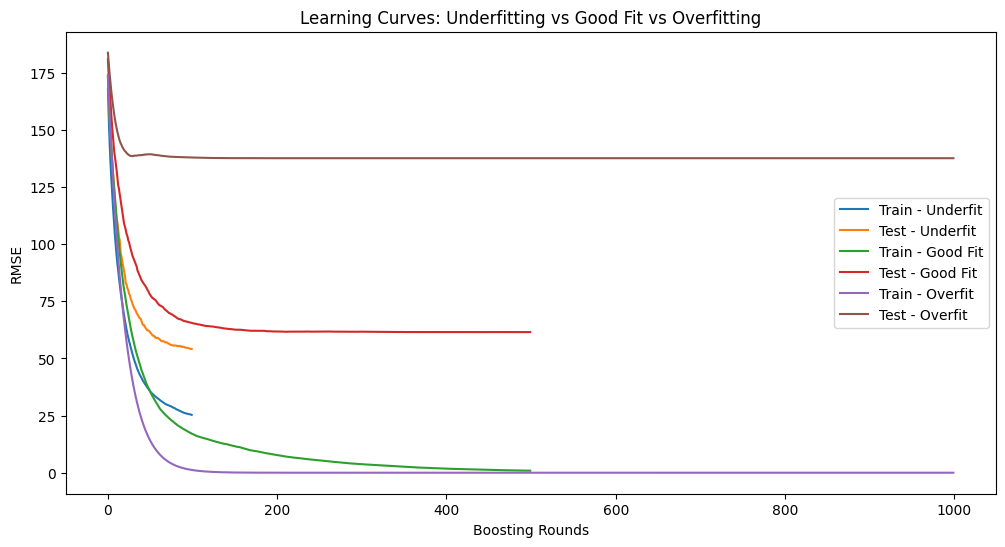

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'gamma': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'reg_lambda': 1}
Best CV Score (MSE): 3724.4582271880595
Test MSE: 2760.9442892671045


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# -----------------------------
# 1. Synthetic dataset
# -----------------------------
X, y = make_regression(
    n_samples=800, n_features=20, noise=25, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 2. Function to plot learning curves
# -----------------------------
def plot_learning_curve(model, X_train, y_train, X_test, y_test, label):
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=eval_set,
              verbose=False)

    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    plt.plot(x_axis, results['validation_0']['rmse'], label=f'Train - {label}')
    plt.plot(x_axis, results['validation_1']['rmse'], label=f'Test - {label}')

# -----------------------------
# 3. Compare underfitting, good fit, overfitting
# -----------------------------
plt.figure(figsize=(12, 6))

# Underfitting model (too simple)
underfit_model = XGBRegressor(
    n_estimators=100, max_depth=2, learning_rate=0.3,
    subsample=1, colsample_bytree=1, random_state=42
)
plot_learning_curve(underfit_model, X_train, y_train, X_test, y_test, "Underfit")

# Balanced model (good fit)
good_model = XGBRegressor(
    n_estimators=500, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
plot_learning_curve(good_model, X_train, y_train, X_test, y_test, "Good Fit")

# Overfitting model (too complex, no regularization)
overfit_model = XGBRegressor(
    n_estimators=1000, max_depth=10, learning_rate=0.05,
    subsample=1, colsample_bytree=1, reg_lambda=0, random_state=42
)
plot_learning_curve(overfit_model, X_train, y_train, X_test, y_test, "Overfit")

plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Learning Curves: Underfitting vs Good Fit vs Overfitting")
plt.legend()
plt.show()

# -----------------------------
# 4. Hyperparameter tuning with GridSearchCV
# -----------------------------
param_grid = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3],
    "reg_lambda": [0.1, 1, 10]
}

grid = GridSearchCV(
    XGBRegressor(
        learning_rate=0.1, n_estimators=500,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score (MSE):", -grid.best_score_)

# Evaluate best model on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))


## **XGBClassifier**

XGBoost has many knobs to tune. They fall into 4 broad categories:

---

### 1. **Tree complexity (model capacity)**

These control **bias vs variance** (underfitting vs overfitting).

* `max_depth`: Maximum depth of each tree.

  * Too small → high bias (underfit).
  * Too large → high variance (overfit).
* `min_child_weight`: Minimum sum of instance weights (hessian) needed in a child node.

  * Larger → more conservative splits (prevents overfitting).
* `gamma`: Minimum loss reduction required to make a split.

  * Larger → fewer splits (more conservative).

---

### 2. **Sampling techniques (regularization via randomness)**

These help reduce variance and prevent overfitting.

* `subsample`: Fraction of rows sampled for each tree.

  * Lower → reduces variance (like bagging).
* `colsample_bytree` / `colsample_bylevel`: Fraction of features sampled.

  * Prevents reliance on a few strong features.

---

### 3. **Regularization parameters (explicit penalties)**

* `reg_lambda` (L2 penalty): Shrinks weights (default = 1). Helps prevent overfitting.
* `reg_alpha` (L1 penalty): Drives some weights to zero (feature selection effect).

---

### 4. **Boosting process (learning dynamics)**

* `learning_rate (eta)`: Step size shrinkage.

  * Small → requires more trees but generalizes better.
* `n_estimators`: Number of trees (boosting rounds).

  * Too high without regularization → overfit.
* `scale_pos_weight`: For handling imbalanced classes.

---

## Handling Underfitting & Overfitting

### Underfitting (model too simple)

Symptoms:

* Both training and test accuracy are low.
* Training loss is high.

Fix:

* Increase `max_depth` or decrease `min_child_weight`.
* Decrease `gamma` (allow more splits).
* Increase `n_estimators`.
* Lower regularization (`reg_lambda`, `reg_alpha`).
* Increase learning rate (to learn faster).

---

### Overfitting (model too complex)

Symptoms:

* Training accuracy is very high, but test accuracy is low.
* Training loss keeps decreasing but validation loss increases.

Fix:

* Reduce `max_depth`.
* Increase `min_child_weight` (more conservative splits).
* Increase `gamma`.
* Use smaller `learning_rate` with larger `n_estimators`.
* Use subsampling (`subsample < 1`, `colsample_bytree < 1`).
* Increase regularization (`reg_lambda`, `reg_alpha`).
* Use early stopping (`early_stopping_rounds`).

---

## 🔹 Hyperparameter Tuning Strategy

1. **Start with learning rate and n\_estimators**

   * Choose a small learning rate (0.05–0.1).
   * Increase `n_estimators` accordingly.

2. **Tune tree depth & min\_child\_weight**

   * Grid search typical values: `max_depth = [3,5,7]`, `min_child_weight = [1,3,5]`.

3. **Tune gamma**

   * Try `gamma = [0, 0.1, 0.3, 0.5]`.

4. **Tune subsample & colsample\_bytree**

   * Try `[0.6, 0.8, 1.0]`.

5. **Add regularization**

   * Adjust `reg_lambda` and `reg_alpha`.

6. **Use cross-validation + early stopping**

   * Prevents overfitting while tuning.

---

# 🔹 Example in Practice



In [5]:
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
# Dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Hyperparameter grid
param_grid = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.2, 0.4],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [1, 5, 10]
}

# Grid Search
grid = GridSearchCV(model, param_grid, scoring="accuracy", cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))



Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.4, 'max_depth': 5, 'min_child_weight': 1, 'reg_lambda': 10, 'subsample': 1.0}
Test Accuracy: 0.895
